<a href="https://colab.research.google.com/github/bathaee/QGAN-EQ-GAN/blob/main/test_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit --upgrade
!pip install qiskit-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00


In [22]:
from qiskit import QuantumCircuit, execute, Aer,transpile
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import algorithm_globals

['cx', 'cz', 'id', 'rz', 'sx', 'z']
     ┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2 


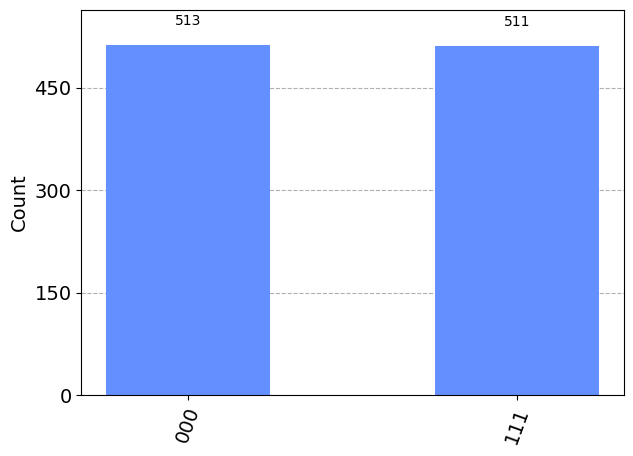

In [140]:
# Error probabilities
prob_1 = 0.01  # 1-qubit gate
prob_2 = 0.01  # 2-qubit gate
prob_m = 0.1   # Measurment error

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
error_meas = noise.pauli_error([('X',prob_m), ('I', 1 - prob_m)])

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['z'])
noise_model.add_all_qubit_quantum_error(error_2, ['cz'])
noise_model.add_all_qubit_quantum_error(error_meas, "measure")

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

print(basis_gates)

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])
print(circ)

result = execute(circ, Aer.get_backend('qasm_simulator')).result()
counts = result.get_counts(0)
plot_histogram(counts)


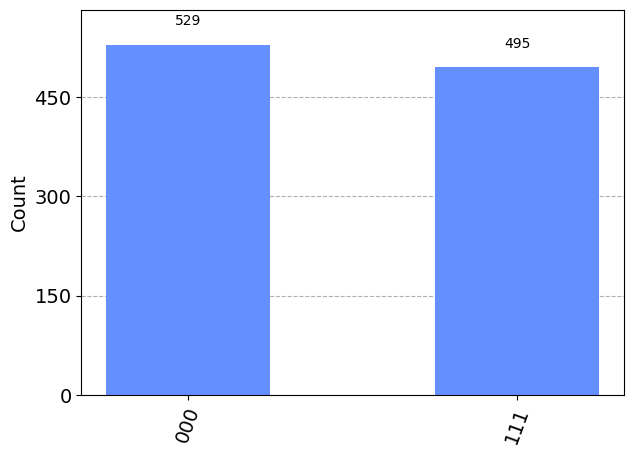

In [109]:
resultn = execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model).result()
countsn = resultn.get_counts(0)
plot_histogram(countsn)

global phase: π/4
     ┌─────────┐┌────┐┌─────────┐          ┌─┐      
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■───────┤M├──────
     └─────────┘└────┘└─────────┘┌─┴─┐     └╥┘┌─┐   
q_1: ────────────────────────────┤ X ├──■───╫─┤M├───
                                 └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ─────────────────────────────────┤ X ├─╫──╫─┤M├
                                      └───┘ ║  ║ └╥┘
c: 3/═══════════════════════════════════════╩══╩══╩═
                                            0  1  2 


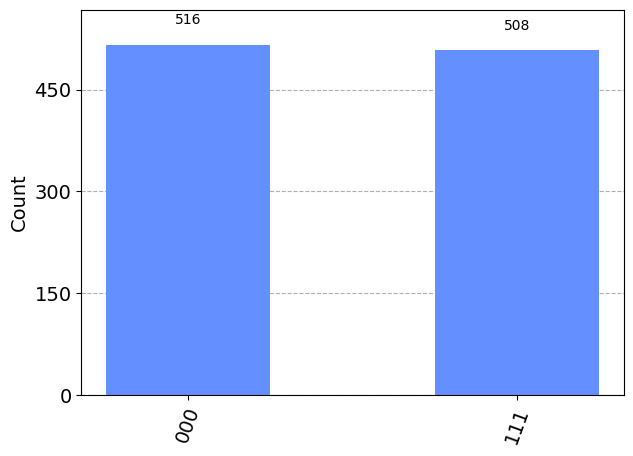

In [107]:
sim_noise = AerSimulator(noise_model=noise_model)
qcnoise = transpile(circ, sim_noise)
print(qcnoise)
resultn2 = execute(qcnoise, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model).result()
countsn2 = resultn2.get_counts(0)
plot_histogram(countsn2)




        ┌─────────┐┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐»
   q_0: ┤ U2(0,π) ├┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├»
        ├─────────┤├──────────┤├──────────┤ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤»
   q_1: ┤ U2(0,π) ├┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├─░─┤ X ├─░─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├»
        └─────────┘└──────────┘└──────────┘ ░ └───┘ ░ └──────────┘└──────────┘»
meas: 2/══════════════════════════════════════════════════════════════════════»
                                                                              »
«         ░ ┌─┐   
«   q_0: ─░─┤M├───
«         ░ └╥┘┌─┐
«   q_1: ─░──╫─┤M├
«         ░  ║ └╥┘
«meas: 2/════╩══╩═
«            0  1 


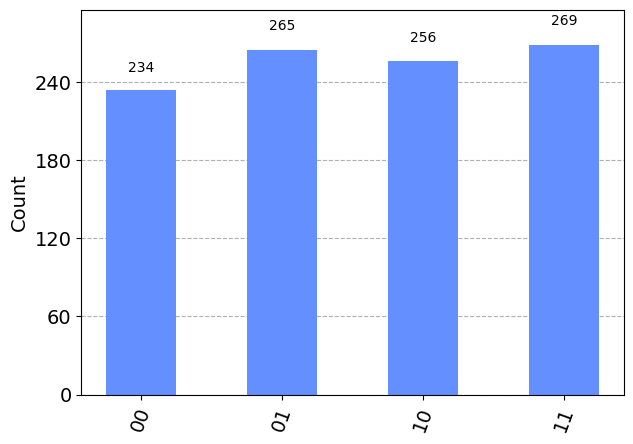

In [141]:
algorithm_globals.random_seed = 123456

shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed })

num_qubits =2
qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=1,insert_barriers=True)
qc.compose(ansatz, inplace=True)
#initial_weights = algorithm_globals.random.random(qc.num_parameters)
initial_weights = [0.63651375, 0.38481166, 0.04744542, 0.95525274, 0.90605094,
       0.45696955, 0.28053348, 0.6361488 , 0.98071069, 0.81243179,
       0.30519824, 0.56801096]

qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=initial_weights,
        sparse=False,
    )
print(qnn.circuit.decompose())

result3 = execute(qnn.circuit, Aer.get_backend('qasm_simulator')).result()
counts3 = result3.get_counts(0)
plot_histogram(counts3)







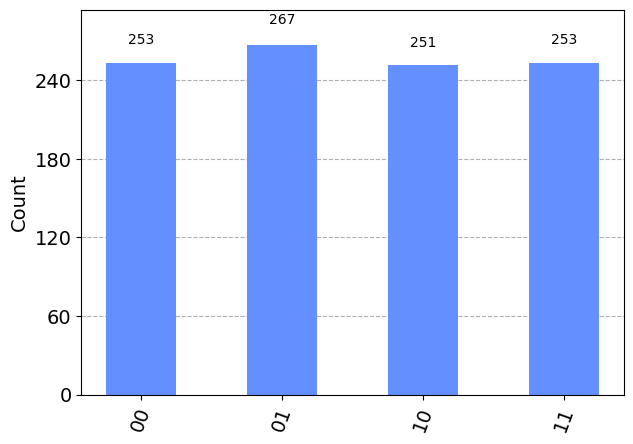

In [142]:
resultn3 = execute(qnn.circuit, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model).result()
countsn3 = resultn3.get_counts(0)
plot_histogram(countsn3)

global phase: π
        ┌────────┐┌────┐┌─────────┐┌──────────────┐┌────┐┌────────┐┌──────────┐»
   q_0: ┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ[0] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[2]) ├»
        ├────────┤├────┤├─────────┤├──────────────┤├────┤├────────┤├──────────┤»
   q_1: ┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ[1] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[3]) ├»
        └────────┘└────┘└─────────┘└──────────────┘└────┘└────────┘└──────────┘»
meas: 2/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«         ░       ░ ┌────┐┌──────────────┐┌────┐┌────────┐┌──────────┐ ░ ┌─┐   
«   q_0: ─░───■───░─┤ √X ├┤ Rz(θ[4] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[6]) ├─░─┤M├───
«         ░ ┌─┴─┐ ░ ├────┤├──────────────┤├────┤├────────┤├──────────┤ ░ └╥┘┌─┐
«   q_1: ─░─┤ X ├─░─┤ √X ├┤ Rz(θ[5] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[7]) ├─░──╫─┤M├
«         ░ └───┘ ░ └────┘└──────────────┘└────┘└────────┘└──────────┘ ░  ║ └╥┘
«meas: 2/════════

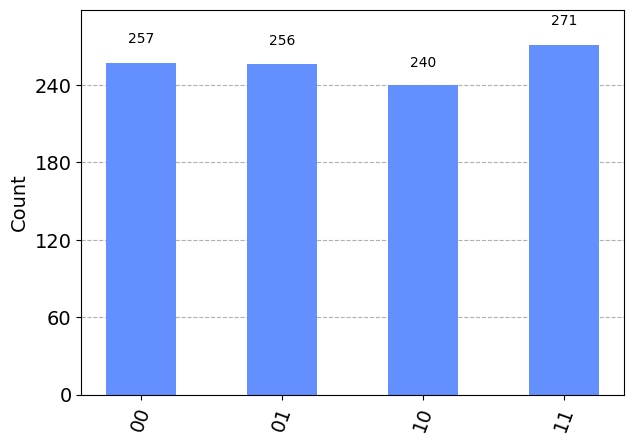

In [143]:
sim_noise1 = AerSimulator(noise_model=noise_model)
qcnoise1 = transpile(qnn.circuit, sim_noise1)
print(qcnoise1)
resultn4 = execute(qcnoise1, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model).result()
countsn4 = resultn4.get_counts(0)
plot_histogram(countsn4)

In [10]:
def get_noise(p_meas,p_gate):

    error_meas = noise.pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = noise.depolarizing_error(p_gate, 1)
    error_gate2 = noise.error_gate1.tensor(error_gate1)

    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["y"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [11]:
sim_noise = AerSimulator(noise_model=noise_model)
qcnoise = transpile(circ, sim_noise)
print(qcnoise)
print(circ)

     ┌─────────┐          ┌─┐      
q_0: ┤ U2(0,π) ├──■───────┤M├──────
     └─────────┘┌─┴─┐     └╥┘┌─┐   
q_1: ───────────┤ X ├──■───╫─┤M├───
                └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ────────────────┤ X ├─╫──╫─┤M├
                     └───┘ ║  ║ └╥┘
c: 3/══════════════════════╩══╩══╩═
                           0  1  2 
     ┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2 
